### Quick note before starting the experiment

This experiment uses the high-level Keras API for TensorFlow, which is one of the simplest ways to construct neural networks. However, if you want to explore a lower-level library, I suggest PyTorch due to its popularity and a more intuitive design compared to TensorFlow. Sources:

- [Keras API](https://keras.io/api/)
- [PyTorch](https://pytorch.org/)
- [TensorFlow](https://www.tensorflow.org/)

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
import tensorflow
import pandas as pd
import numpy as np
import random
import sklearn
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt
from IPython.core.display import Markdown
import optuna
import time

c:\Users\armin\Projects\teachingML\teachingML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_file = "download-2.csv"

data = pd.read_csv(path_to_file).query('Type == "QMLE-Trade"').set_index("Date")["Volatility"]

In [3]:
train_split_idx = int(len(data) * 0.8)

y_train_init = data.iloc[:train_split_idx]
y_test_init = data.iloc[train_split_idx:]

# Pre-process (Min-Max scaling)
max_scale = y_train_init.max()
min_scale = y_train_init.min()

def scale_func(arr_to_scale):
    return (arr_to_scale - min_scale) / (max_scale - min_scale)

def scale_func_inverse(arr_to_scale):
    return arr_to_scale * (max_scale - min_scale) + min_scale

y_train_init = scale_func(y_train_init)
y_test_init = scale_func(y_test_init)

In [4]:
def create_sequences(data_to_transform, seq_length):
    n_data = len(data_to_transform)
    sequential_data = np.zeros((n_data - seq_length, seq_length,))

    for i in range(n_data - seq_length):
        sequential_data[i] = data_to_transform[i:i+seq_length]

    return sequential_data

In [5]:
def generate_sequential_data(seq_length):
    seq_length = 10

    X_train = create_sequences(y_train_init, seq_length)
    X_test = create_sequences(y_test_init, seq_length)

    X_test_complement = np.zeros((seq_length, seq_length))

    for i in range(seq_length):
        row = np.concatenate([np.array(y_train_init)[-seq_length+i:], np.array(y_test_init)[:i]])
        X_test_complement[i] = row

    y_train = y_train_init[seq_length:]
    X_test = np.concatenate([X_test_complement, X_test])

    return X_train, y_train, X_test

In [6]:
class NeuralNetwork:
    def __init__(self):
        self._set_seed()
    
    def _set_seed(self):
        random.seed(0)
        np.random.seed(0)
        tensorflow.random.set_seed(0)
       
    def train_model(self, x, y):
        history: keras.callbacks.History = self.model.fit(
            x=x,
            y=y,
            batch_size=self.params["batch_size"],
            epochs=self.params["epochs"],
            verbose=self.params["verbose"],
            shuffle=False,
            validation_split=self.params["validation_split"],
        )

        return min(history.history["val_loss"]) if "val_loss" in history.history else None
    
    def predict(self, x):
        return scale_func_inverse(self.model.predict(x=x))

In [7]:
# HELPER FUNCTIONS

# Model Testing
def plot_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label="y_true", linewidth=0.6, color="blue")
    plt.plot(y_pred, label="y_pred", linewidth=0.6, color="red")
    plt.legend()
    plt.title("True vs Predicted Volatility")
    plt.show()

def test_model(y_true, y_pred, plot=True):
    rmse = sklearn.metrics.root_mean_squared_error(y_pred, y_true)

    if plot: plot_true_vs_pred(y_true, y_pred)

    return rmse


# Hyperparameter Optimization (More on this in Week 6)
def tune_model(objective_func):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=1))
    study.optimize(objective_func, n_trials=50)

    print("\n\n" + "-" * 80)
    print(f"Best params:\n{study.best_params}")
    return study.best_params

### Neural Network structure decisions:

- Number of hidden layers fixed at 1
    - <small>By the universal approximation theorem, 1 layer is already enough to approximate any function within any small error (verify why the inputs here form a compact subset). More layers often overcomplicate fitting and should only be used in more complex tasks. Additionally, it is faster to train.</small>
- Activation function: softplus
    - <small>Introduces non-linearity</small>
    - <small>Avoids dying neuron problem</small>
    - <small>Always positive (Is it always an advantage? Why is it for this task?)</small>
    - <small>Stable gradients</small>
- Optimizer: Adam
    - <small>It is fast, proven to work well</small>

In [8]:
# Start timer
start_time = time.perf_counter()

# Feedfoward Neural Network

In [9]:
# Introduce lags and adjust sets
X_train = y_train_init.shift(1)
X_test = y_test_init.shift(1)
X_test.iloc[0] = y_train_init.iloc[-1]

X_train = X_train.iloc[1:]
y_train = y_train_init.iloc[1:]

In [10]:
class FeedforwardNN(NeuralNetwork):
    def __init__(self, input_dim, params=dict()):
        super().__init__()
        self.params = {
            "learning_rate": 1e-3,
            "batch_size": 32,
            "epochs": 100,
            "n_neurons": 32,
            "verbose": 1,
            "validation_split": 0.0,
        }
        if params:
            self.params.update(params)
        
        self.model = keras.models.Sequential(name="FeedforwardNN")
        self.setup_model_architecture(input_dim)
        self.model.compile(
            loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=self.params["learning_rate"]),
        )
    
    def setup_model_architecture(self, input_dim):
        self.model.add(keras.Input(shape=(input_dim,)))
        self.model.add(layers.Dense(self.params["n_neurons"], activation="softplus"))
        self.model.add(layers.Dense(1))

In [11]:
def objective_fnn(trial: optuna.trial.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-3),
        "batch_size": trial.suggest_int("batch_size", 16, 64, step=4),
        "n_neurons": trial.suggest_int("n_neurons", 16, 96, step=4),
        "epochs": 20, # For tuning, train with less epochs
        "validation_split": 0.2,
        "verbose": 0,
    }

    return FeedforwardNN(input_dim=1, params=params).train_model(X_train, y_train)

best_params_fnn = tune_model(objective_func=objective_fnn)

[I 2025-08-30 00:46:09,949] A new study created in memory with name: no-name-a0fbebaf-640e-41c6-8900-c894e2ed6669
[I 2025-08-30 00:46:13,326] Trial 0 finished with value: 0.0009279960650019348 and parameters: {'learning_rate': 0.0004753198042323166, 'batch_size': 52, 'n_neurons': 16}. Best is trial 0 with value: 0.0009279960650019348.
[I 2025-08-30 00:46:18,108] Trial 1 finished with value: 0.000551564444322139 and parameters: {'learning_rate': 0.00037209931536865575, 'batch_size': 20, 'n_neurons': 20}. Best is trial 1 with value: 0.000551564444322139.
[I 2025-08-30 00:46:21,874] Trial 2 finished with value: 0.0008957486134022474 and parameters: {'learning_rate': 0.0002676341902399038, 'batch_size': 32, 'n_neurons': 48}. Best is trial 1 with value: 0.000551564444322139.
[I 2025-08-30 00:46:25,471] Trial 3 finished with value: 0.0005392413586378098 and parameters: {'learning_rate': 0.0005849350606030213, 'batch_size': 36, 'n_neurons': 72}. Best is trial 3 with value: 0.00053924135863780



--------------------------------------------------------------------------------
Best params:
{'learning_rate': 0.0009327901760833035, 'batch_size': 20, 'n_neurons': 24}


Epoch 1/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - loss: 0.3491
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0025
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0023
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.0022
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0020
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.0019
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0018
Epoch 8/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0017
Epoch 9/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0017
Epoch 10/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.0016
Epoch 11/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0016
Epoch 12/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0016
Epoch 13/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0015
Epoch 14/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0015
Epoch 15/100
29

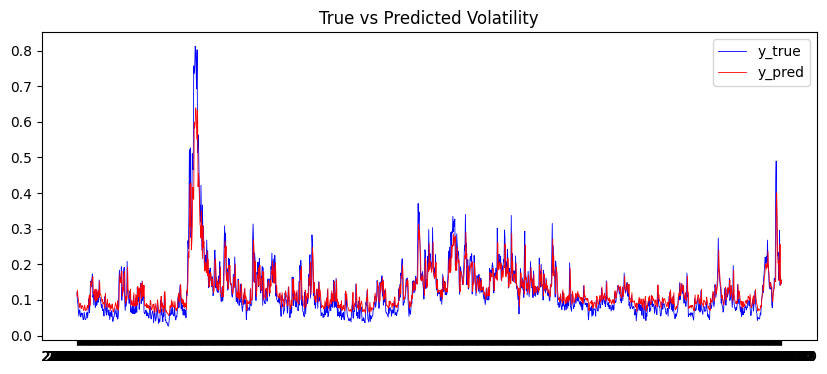

Test RMSE: 0.0410


In [12]:
feedforward_nn = FeedforwardNN(input_dim=1, params=best_params_fnn)
feedforward_nn.train_model(X_train, y_train)

feedforward_nn_rmse = test_model(scale_func_inverse(y_test_init), feedforward_nn.predict(X_test))
print(f"Test RMSE: {feedforward_nn_rmse:.4f}")

# Recurrent Neural Network

In [13]:
seq_length = 22 # One month

X_train, y_train, X_test = generate_sequential_data(seq_length)

In [14]:
class RecurrentNN(NeuralNetwork):
    def __init__(self, input_dim, seq_length, params = dict()):
        super().__init__()
        self.params = {
            "learning_rate": 1e-3,
            "batch_size": 32,
            "epochs": 100,
            "n_neurons": 32,
            "verbose": 1,
            "validation_split": 0.0,
        }
        if params:
            self.params.update(params)

        self.model = keras.models.Sequential(name="SimpleRNN")
        self.setup_model_architecture(input_dim, seq_length)
        self.model.compile(
            loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=self.params["learning_rate"]),
        )
    
    def setup_model_architecture(self, input_dim, seq_length):
        self.model.add(keras.Input(shape=(seq_length, input_dim,)))
        self.model.add(layers.SimpleRNN(self.params["n_neurons"], activation="softplus", return_sequences=False))
        self.model.add(layers.Dense(1))

In [15]:
def objective_rnn(trial: optuna.trial.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-3),
        "batch_size": trial.suggest_int("batch_size", 16, 64, step=4),
        "n_neurons": trial.suggest_int("n_neurons", 16, 96, step=4),
        "epochs": 20, # For tuning, train with less epochs
        "validation_split": 0.2,
        "verbose": 0,
    }

    return RecurrentNN(input_dim=1, seq_length=seq_length, params=params).train_model(X_train, y_train)

best_params_rnn = tune_model(objective_func=objective_rnn)

[I 2025-08-30 00:50:49,701] A new study created in memory with name: no-name-03bb0481-ec49-4bcb-b2bd-394e4f1c222e
[I 2025-08-30 00:50:55,011] Trial 0 finished with value: 0.0008403906831517816 and parameters: {'learning_rate': 0.0004753198042323166, 'batch_size': 52, 'n_neurons': 16}. Best is trial 0 with value: 0.0008403906831517816.
[I 2025-08-30 00:51:04,918] Trial 1 finished with value: 0.0006266074487939477 and parameters: {'learning_rate': 0.00037209931536865575, 'batch_size': 20, 'n_neurons': 20}. Best is trial 1 with value: 0.0006266074487939477.
[I 2025-08-30 00:51:12,387] Trial 2 finished with value: 0.000805907417088747 and parameters: {'learning_rate': 0.0002676341902399038, 'batch_size': 32, 'n_neurons': 48}. Best is trial 1 with value: 0.0006266074487939477.
[I 2025-08-30 00:51:19,950] Trial 3 finished with value: 0.0006454278482124209 and parameters: {'learning_rate': 0.0005849350606030213, 'batch_size': 36, 'n_neurons': 72}. Best is trial 1 with value: 0.000626607448793



--------------------------------------------------------------------------------
Best params:
{'learning_rate': 0.0006610216335794297, 'batch_size': 28, 'n_neurons': 24}


Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 9/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020
Epoch 10/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 
Epoch 11/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 12/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 
Epoch 13/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016
Epoch 14/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 
Epoch 15/100
209/209 ━━━━━━━━━━━━━━━━━━━

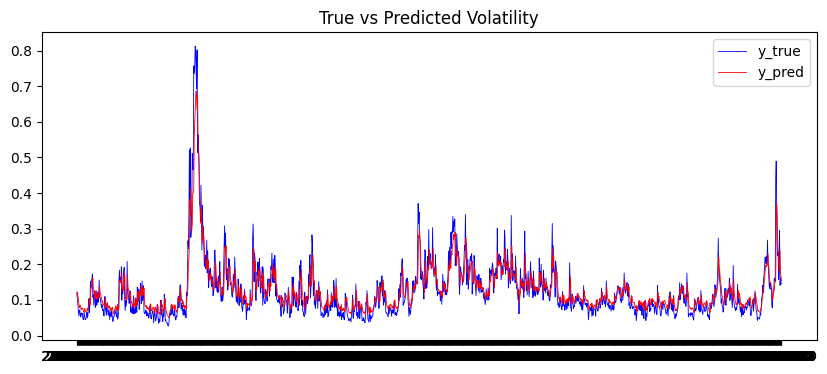

Test RMSE: 0.0388


In [16]:
recurrent_nn = RecurrentNN(input_dim=1, seq_length=seq_length, params=best_params_rnn)
recurrent_nn.train_model(X_train, y_train)

recurrent_nn_rmse = test_model(scale_func_inverse(y_test_init), recurrent_nn.predict(X_test))

print(f"Test RMSE: {recurrent_nn_rmse:.4f}")

# Long Short-Term Memory RNN

In [17]:
seq_length = 22

X_train, y_train, X_test = generate_sequential_data(seq_length)

In [18]:
class LSTM(NeuralNetwork):
    def __init__(self, input_dim, seq_length, params = dict()):
        super().__init__()
        self.params = {
            "learning_rate": 1e-3,
            "batch_size": 32,
            "epochs": 100,
            "n_neurons": 32,
            "verbose": 1,
            "validation_split": 0.0
        }
        if params:
            self.params.update(params)

        self.model = keras.models.Sequential(name="LSTM")
        self.setup_model_architecture(input_dim, seq_length)
        self.model.compile(
            loss=keras.losses.MeanSquaredError(),
            optimizer=keras.optimizers.Adam(learning_rate=self.params["learning_rate"]),
        )
    
    def setup_model_architecture(self, input_dim, seq_length):
        self.model.add(keras.Input(shape=(seq_length, input_dim,)))
        self.model.add(layers.LSTM(self.params["n_neurons"], activation="softplus", return_sequences=False))
        self.model.add(layers.Dense(1))

In [19]:
def objective_lstm(trial: optuna.trial.Trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-3),
        "batch_size": trial.suggest_int("batch_size", 16, 64, step=4),
        "n_neurons": trial.suggest_int("n_neurons", 16, 96, step=4),
        "epochs": 20, # For tuning, train with less epochs
        "validation_split": 0.2,
        "verbose": 0,
    }

    return LSTM(input_dim=1, seq_length=seq_length, params=params).train_model(X_train, y_train)

best_params_lstm = tune_model(objective_func=objective_lstm)

[I 2025-08-30 00:57:17,936] A new study created in memory with name: no-name-6aadf04b-b960-46bf-9bd8-97e048dc0fd0
[I 2025-08-30 00:57:24,219] Trial 0 finished with value: 0.0005982998991385102 and parameters: {'learning_rate': 0.0004753198042323166, 'batch_size': 52, 'n_neurons': 16}. Best is trial 0 with value: 0.0005982998991385102.
[I 2025-08-30 00:57:35,150] Trial 1 finished with value: 0.0005549442139454186 and parameters: {'learning_rate': 0.00037209931536865575, 'batch_size': 20, 'n_neurons': 20}. Best is trial 1 with value: 0.0005549442139454186.
[I 2025-08-30 00:57:45,216] Trial 2 finished with value: 0.0005440869135782123 and parameters: {'learning_rate': 0.0002676341902399038, 'batch_size': 32, 'n_neurons': 48}. Best is trial 2 with value: 0.0005440869135782123.
[I 2025-08-30 00:57:56,400] Trial 3 finished with value: 0.0006448448402807117 and parameters: {'learning_rate': 0.0005849350606030213, 'batch_size': 36, 'n_neurons': 72}. Best is trial 2 with value: 0.00054408691357



--------------------------------------------------------------------------------
Best params:
{'learning_rate': 0.0008420715786225749, 'batch_size': 36, 'n_neurons': 48}


Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0461
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 9/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 10/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 11/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 12/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 13/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 14/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 15/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 0

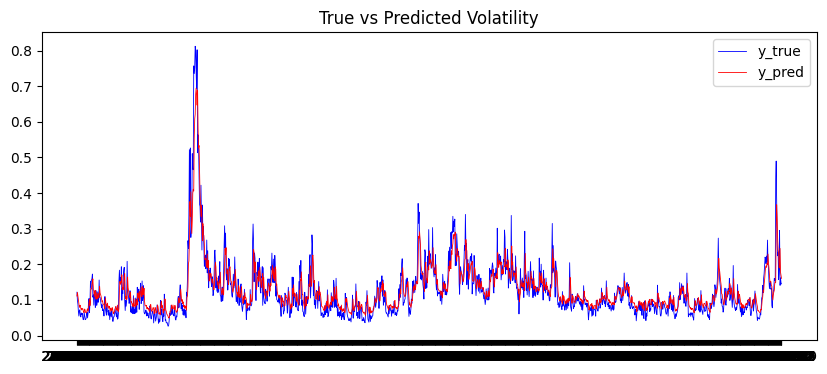

Test RMSE: 0.0387


In [20]:
lstm = LSTM(input_dim=1, seq_length=seq_length, params=None)
lstm.train_model(X_train, y_train)

lstm_rmse = test_model(scale_func_inverse(y_test_init), lstm.predict(X_test))
print(f"Test RMSE: {lstm_rmse:.4f}")

In [21]:
display(Markdown(f"""
### Final RMSE Values
{'-'*100}  
| Algorithm                             | Test RMSE                |
|-------------------------------------|-------------------------:|
| **Feedforward NN**                         | {feedforward_nn_rmse:.4f}  | 
| **Simple RNN**                     | {recurrent_nn_rmse:.4f}      |
| **LSTM**                   | {lstm_rmse:.4f}       |
{'-'*100}
Total runtime: {time.perf_counter() - start_time:.2f} seconds
"""))


### Final RMSE Values
----------------------------------------------------------------------------------------------------  
| Algorithm                             | Test RMSE                |
|-------------------------------------|-------------------------:|
| **Feedforward NN**                         | 0.0410  | 
| **Simple RNN**                     | 0.0388      |
| **LSTM**                   | 0.0387       |
----------------------------------------------------------------------------------------------------
Total runtime: 1254.56 seconds
